<a href="https://colab.research.google.com/github/LunarByteFlow/Machine-Learning/blob/master/02_Neural_network_classification_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural network classification with pytorch
Classification is a problem of predicting weather something is one thing or another (there can be multiple things as the options such as an email if it is spam or not spam)

### Make classification data and get it ready

In [ ]:
import sklearn
import torch
from sklearn.datasets import make_circles
# make a 1000 datasets
n_samples = 1000
# Make features and labels
X,y = make_circles(n_samples, noise = 0.03, random_state = 42)
# y = make_circles(n_samples, noise = 0.03, random_state = 42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Dividing the data into train and data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

print(f"X_train: {len(X_train)}")
print(f"X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}")
print(f"y_test: {len(y_test)}")
print(f"The number of samples are: {n_samples}")

X_train: 800
X_test: 200
y_train: 800
y_test: 200
The number of samples are: 1000


## Bulding a model
Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator if there is one.
2. construct as model by subclassing (`nn.Module`)
3. Setup loss function and optimizer
4. Setup training loop.

In [ ]:
import torch
from torch import nn
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Now we've setup device agnostic doe , lets create a model.
1. we're going to sub class `nn.Module`(alost all classes in pytorch do this)
2. Than create `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Define a `forward()` that outlines the forward pass (or froward computation of our model).
4. instantiate an instance of our model class and send it to the target device.

In [ ]:
# Building a Model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer_11 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # X -> layer2 -> layer1



In [ ]:
# model_0 = CircleModelV0().to(device)
model_0 = CircleModelV0()
model_0

CircleModelV0(
  (Layer_11): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
next(model_0.parameters()).device


device(type='cpu')

In [ ]:
# Replicate the model using nn.Sequential()
model_0 = nn.Sequential(nn.Linear(in_features = 2, out_features =5), nn.Linear(in_features = 5, out_features = 1))
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0103,  0.0983],
                      [ 0.3905, -0.4967],
                      [ 0.2257,  0.4019],
                      [ 0.3926, -0.6586],
                      [-0.2698, -0.6078]])),
             ('0.bias', tensor([-0.4475,  0.3938, -0.1056,  0.3003, -0.4151])),
             ('1.weight',
              tensor([[ 0.0680, -0.2705,  0.2236, -0.1956, -0.1121]])),
             ('1.bias', tensor([-0.3880]))])

In [ ]:
with torch.inference_mode():
  y_preds = model_0(X_test)
print(f"The data given to the model\n{X_test[:5]} \nthe Total number of elements in the given dataset: {len(X_test)}")
print(f"The predictions of the model\n{y_preds[:5]}")
print(f"The expected predictions from the model:\n {y_test[:5]}")

The data given to the model
tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438]]) 
the Total number of elements in the given dataset: 200
The predictions of the model
tensor([[-0.2308],
        [-0.1515],
        [-0.6244],
        [-0.1185],
        [-0.9196]])
The expected predictions from the model:
 tensor([1., 0., 1., 0., 1.])


### 2.1 Setup loss function and Optimizer
Which loss function or optimizer should you use.
Again..., this is problem specific.
* For example for regression you might want MAE or MSE (mean absolute error or mean squared error)
* For classification you might use binary corss entropy or cross entropy(categorical cross entropy).
* For Optimizers two of the most Usefull ones are **SGD** and **Adam**, however Pytorch has many nuilt in options.
* For loss function we're going to use `torch.nn.BCEWithLogitsloss()`

In [ ]:
# Setting up a loss function
# loss_fn = BCELoss() # BCELoss = requires the inputs to have gone through the sigmoid activation function prior to input to BCELoss.
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has the sigmoid activation function built in.

optimizer = torch.optim.SGD(params = model_0.parameters(),lr=0.01)
# optimizer = torch.optim.Adam(params = model_0.parameters(),lr=0.001)


# Calculate accuracy - out of 100 how many samples does our model predict right
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc




# Train the Model
We'll follow the following steps to train our model
1. Forward pass.
2. Calculate the loss.
3. Optimizer zero grad.
4. Loss Backwards (Back Propagation).
5. Optimizer step (gradient descent).
6. print whats hapening

### Going from raw logits --> prediction probabilities --> prediction labels
* Our model outputs are goig to be raw **logits**
* Matlab humara model_0 jo bhi prediction dey raha hoga wo basically **logits** hain.
* we can convert **logits** into prediction probabilities by passing them through some kind of activation function.(e.g sigmoid for binary cross entropy and softmax for multiclass classification)
* Then we can convert out model's prediction probabilities by either **rounding them** or taking the **argmax()**

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)
print(f"The data given to out model was:\n {X_test[:10]}, \n from this the raw output that our model generated is :\n {y_logits[:10]}")

The data given to out model was:
 tensor([[-0.3752,  0.6827],
        [ 0.0154,  0.9600],
        [-0.7028, -0.3147],
        [-0.2853,  0.9664],
        [ 0.4024, -0.7438],
        [ 0.6323, -0.5711],
        [ 0.8561,  0.5499],
        [ 1.0034,  0.1903],
        [-0.7489, -0.2951],
        [ 0.0538,  0.9739]]), 
 from this the raw output that our model generated is :
 tensor([[-0.2308],
        [-0.1515],
        [-0.6244],
        [-0.1185],
        [-0.9196],
        [-0.8690],
        [-0.4119],
        [-0.5807],
        [-0.6114],
        [-0.1495]])


In [ ]:
# Now we will be converting our logits to prediction probabilities by passing the y_logits tensor through the sigmoid() fuction
y_pred_prod = torch.sigmoid(y_logits)
print(f"The prediction probabilites after the sigmoid function are:\n{y_pred_prod[:10]}")
y_pred_rounded = torch.round(y_pred_prod)
y_pred_labels =torch.round(torch.sigmoid(model_0(X_test)))
print(f"The prediction labels hence will be {y_pred_labels[:10]}")
print(f"{torch.eq(y_pred_rounded[:10],y_pred_labels[:10]) }")

The prediction probabilites after the sigmoid function are:
tensor([[0.4426],
        [0.4622],
        [0.3488],
        [0.4704],
        [0.2850],
        [0.2955],
        [0.3984],
        [0.3588],
        [0.3517],
        [0.4627]])
The prediction labels hence will be tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)
tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


In [ ]:
### Building Training and test Loop
torch.manual_seed(42)
epochs = 100
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)



##Building th Train and Test Loop.

In [ ]:
torch.manual_seed(42)
# set the number of epochs
epochs =100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Building the train and test loop
for epochs in range(epochs):
  # enter the model into the training loop.
  model_0.train()
  # forward pass
  y_logits = model_0(X_train)
  y_preds= torch.round(torch.sigmoid(y_logits))

  #  calculate the loss.
  loss = loss_fn(y_logits.squeeze(), y_train); # nn.BCEWithLogitsLoss() expects raw logits as input
  acc = accuracy_fn(y_true=y_train,y_pred=y_preds);

  # optimizer Zero grad
  optimizer.zero_grad()

  # loss baskward (back propagation)
  loss.backward()
  # optimizer step
  optimizer.step()
  model_0.eval()


  with torch.inference_mode():
  # Test Logits
    test_logits = model_0(X_test).squeeze();
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)


  # Calculate the test loss/acc
  test_loss = loss_fn(test_logits,y_test)
  test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)


  if epochs % 10 ==0:
    print(f"Epoch | {epochs}")
    print(f"The Loss loss of the model during Training: {loss:.5f} \n")
    print(f"The test loss of the model during Testing: {test_loss:.5f} \n")
    print(f"The accuracy of the model: {test_acc:.3f} \n")








Epoch | 0
The Loss loss of the model during Training: 0.74006 

The test loss of the model during Testing: 0.74481 

The accuracy of the model: 0.500 

Epoch | 10
The Loss loss of the model during Training: 0.73632 

The test loss of the model during Testing: 0.74125 

The accuracy of the model: 0.500 

Epoch | 20
The Loss loss of the model during Training: 0.73290 

The test loss of the model during Testing: 0.73801 

The accuracy of the model: 0.500 

Epoch | 30
The Loss loss of the model during Training: 0.72976 

The test loss of the model during Testing: 0.73503 

The accuracy of the model: 0.500 

Epoch | 40
The Loss loss of the model during Training: 0.72689 

The test loss of the model during Testing: 0.73231 

The accuracy of the model: 0.500 

Epoch | 50
The Loss loss of the model during Training: 0.72426 

The test loss of the model during Testing: 0.72981 

The accuracy of the model: 0.500 

Epoch | 60
The Loss loss of the model during Training: 0.72185 

The test loss of t

## making predictions and Evaluating our Model.
* From the metrics it looks like our model is'nt learning anything...
* So to inspect it let's make some predictions and make them visual.!!
* In other owrds 'Visualize, Visualize, Visualize'
* To do you we are going to use a function known as `plot_decision_boundary()`

In [ ]:
import requests
from pathlib import Path

# Download helper function from learn python repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
    print("helper_functions.py downloaded")

helper_functions.py already exists, skipping download


## Now we have helper functions imported from an external resource and we are going to use functions like
* `plot_predictions()`
* `plot_decision_boundary()`


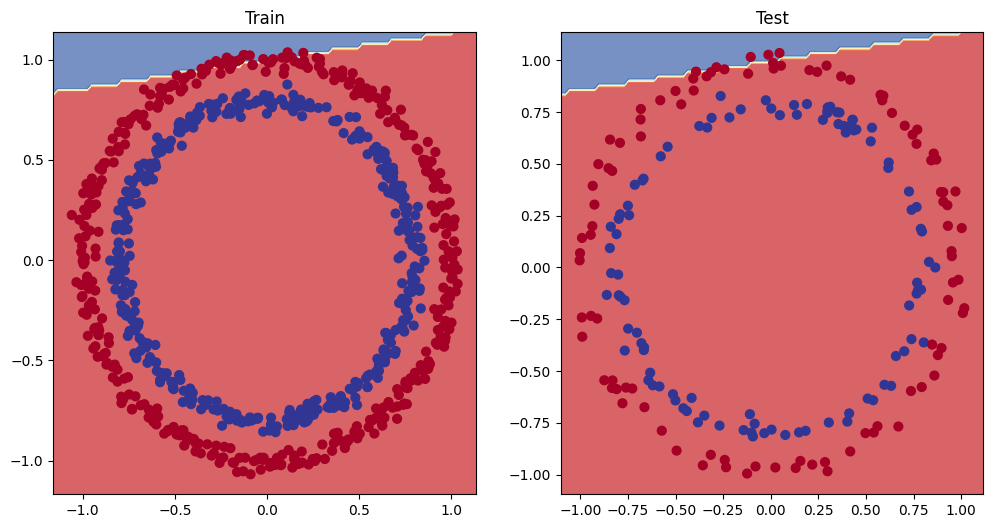

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_0,X_train,y_train)
plt.title("Train")
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## Improving a model (From the perspective of a Model)
* Add more layers - give the model more chances to learn about the data.
* Ad more hidden units - go from 5 hidden units to 10 hidden units.
* fit for longer (every epoch is one pass through the data).
* Changing the activation functions.
* Changing the loss function.
* Changing the optimizer.
* Changing the learning rate.

These values are all from a model's perspective as they deal directly with the model, rather than the data.

And because these options are all values we (as machine Learning Engineers and data scientists) can change, they are referred to as **hyperparameters**

Let try and Improve our Mode:
* Adding More hidden units. 5->10
* adding More hidden layers.2->3
* increase the number of epochs -> 100 -> 1000


In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features=5)
    self.layer_2 = nn.Linear(in_features = 5, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10, out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
model_1 = CircleModelV1().to(device)
model_1
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140],
                      [-0.2060, -0.0524, -0.1816,  0.2967, -0.3530],
                      [-0.2062, -0.1263, -0.2689,  0.0422, -0.4417],
                      [ 0.4039, -0.3799,  0.3453,  0.0744, -0.1452],
                      [ 0.2764,  0.0697,  0.3613,  0.0489, -0.1410],
                      [ 0.1202, -0.1213,  0.1882,  0.3993,  0.2585],
                      [-0.1955,  0.2582,  0.0800,  0.2271, -0.2726],
                      [-0.4427, -0.1728, -0.3430,  0.3670,  0.1288],
                      [ 0.1852,  0.1414, -0.0078,  0.3500, -0.3178],
       

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),lr = 0.01)

In [ ]:
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epochs in range(epochs):
  model_1.train()

  # forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred_labels = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_preds);


  # loss backward
  loss.backward()
  # Optimizer zero grad

  optimizer.zero_grad()

  #optimizer step
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred_labels = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits.squeeze(),y_test.squeeze())
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epochs % 10 ==0:
    print(f"Epoch | {epochs}")
    print(f"The Loss loss of the model during Training: {loss:.5f} \n")
    print(f"The test loss of the model during Testing: {test_loss:.5f} \n")
    print(f"The accuracy of the model: {test_acc:.3f} \n")

Epoch | 0
The Loss loss of the model during Training: 0.70652 

The test loss of the model during Testing: 0.70429 

The accuracy of the model: 0.475 

Epoch | 10
The Loss loss of the model during Training: 0.70652 

The test loss of the model during Testing: 0.70429 

The accuracy of the model: 0.475 

Epoch | 20
The Loss loss of the model during Training: 0.70652 

The test loss of the model during Testing: 0.70429 

The accuracy of the model: 0.475 

Epoch | 30
The Loss loss of the model during Training: 0.70652 

The test loss of the model during Testing: 0.70429 

The accuracy of the model: 0.475 

Epoch | 40
The Loss loss of the model during Training: 0.70652 

The test loss of the model during Testing: 0.70429 

The accuracy of the model: 0.475 

Epoch | 50
The Loss loss of the model during Training: 0.70652 

The test loss of the model during Testing: 0.70429 

The accuracy of the model: 0.475 

Epoch | 60
The Loss loss of the model during Training: 0.70652 

The test loss of t

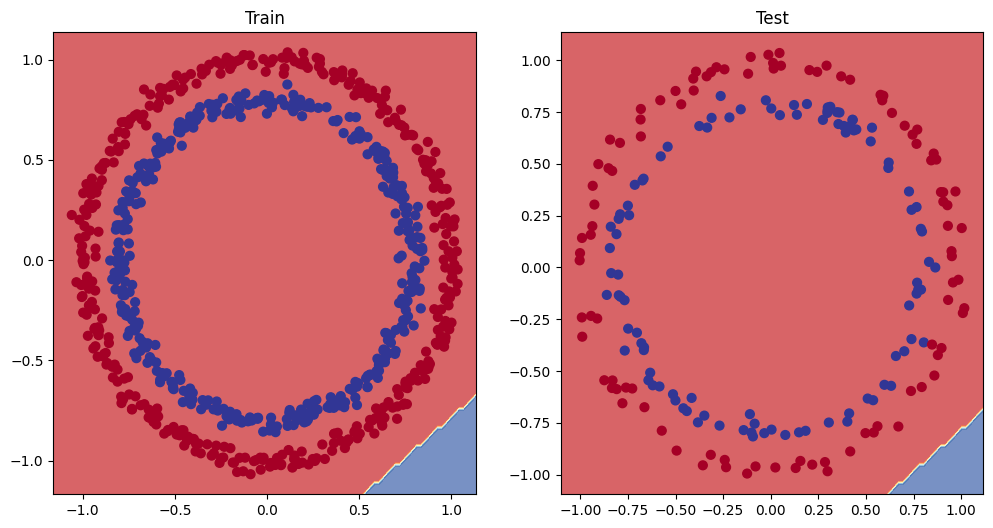

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_1,X_train,y_train)
plt.title("Train")
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### Fitting our Model (model_1) to the Data set we created previously

In [ ]:
from sklearn.model_selection import train_test_split
weight = 0.3
bias = 0.7
start = 0
end = 1
step = 0.01
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = bias + weight*X
X_train_regression,X_test_regression,y_train_regression,y_test_regression = train_test_split(X,y,test_size = 0.2, random_state = 42)
X[:10], y[:10]
len(X_train_regression),len(y_train_regression),len(X_test_regression),len(y_test_regression)


(80, 80, 20, 20)

In [ ]:
class OurNewLinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 1, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 10)
    self.layer_3 = nn.Linear(in_features =10, out_features = 1)
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


In [ ]:
model_linear_regression = OurNewLinearRegressionModel()
model_linear_regression

OurNewLinearRegressionModel(
  (layer_1): Linear(in_features=1, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_linear_regression.parameters(),lr = 0.001)

In [ ]:
epochs = 1000
X_train_regression,X_test_regression,y_train_regression,y_test_regression = X_train_regression.to(device),X_test_regression.to(device),y_train_regression.to(device),y_test_regression.to(device)
for epochs in range(epochs):
  model_linear_regression.train()
  y_model_predictions = model_linear_regression(X_train_regression)
  LR_loss = loss_fn(y_model_predictions,y_train_regression)
  optimizer.zero_grad()
  LR_loss.backward()
  optimizer.step()
  model_linear_regression.eval()
  with torch.inference_mode():
    y_test_predictions = model_linear_regression(X_test_regression)
    test_loss = loss_fn(y_test_predictions,y_test_predictions)


  if epochs % 100 == 0:
    print(f"Epoch | {epochs}")
    print(f"Loss during training : {LR_loss:.5f}")
    print(f"Loss during testing : {test_loss:.5f}")


Epoch | 0
Loss during training : 1.21364
Loss during testing : 0.00000
Epoch | 100
Loss during training : 0.57512
Loss during testing : 0.00000
Epoch | 200
Loss during training : 0.08376
Loss during testing : 0.00000
Epoch | 300
Loss during training : 0.07234
Loss during testing : 0.00000
Epoch | 400
Loss during training : 0.06207
Loss during testing : 0.00000
Epoch | 500
Loss during training : 0.05217
Loss during testing : 0.00000
Epoch | 600
Loss during training : 0.04259
Loss during testing : 0.00000
Epoch | 700
Loss during training : 0.03330
Loss during testing : 0.00000
Epoch | 800
Loss during training : 0.02425
Loss during testing : 0.00000
Epoch | 900
Loss during training : 0.01540
Loss during testing : 0.00000


In [ ]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

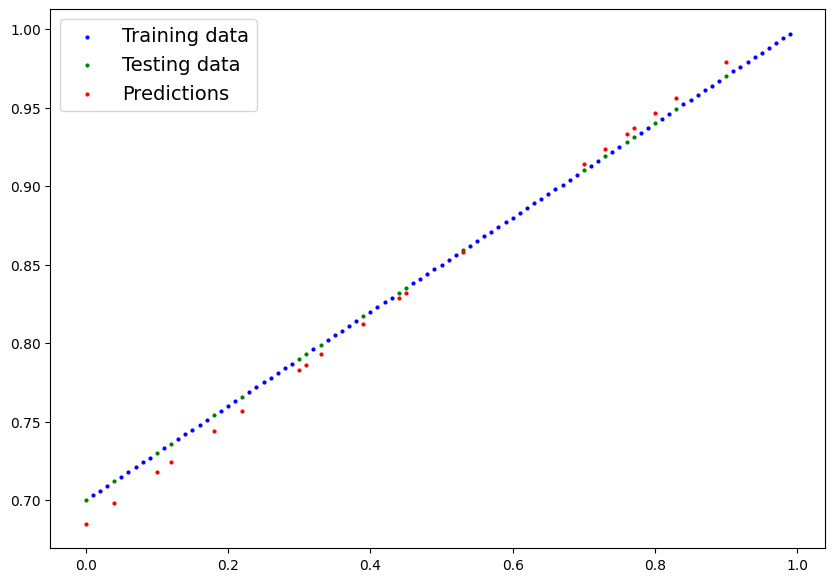

In [ ]:
# In the cell where you call plot_predictions, change the last argument to y_test_predictions
plot_predictions(X_train_regression,y_train_regression,X_test_regression,y_test_regression,predictions=y_test_predictions)

### 6. The missing Piece: non-Linearity
"What patterns could you draw if you were given an infinite amount of straight and non-straight lines"?.


Or in Machine learning Terms an infinite, (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data, make and plot data (Red and Blue Circles)
* Atificial neural networks are a combination of linear and non linear functions which are potentially able to find patterns in data.

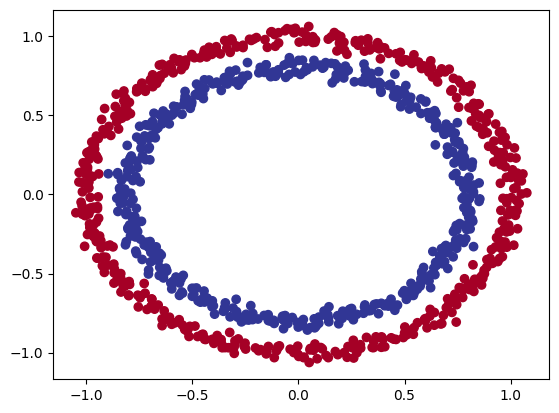

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples =1000
X,y = make_circles(n_samples, noise = 0.03)
plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdYlBu)

## this is the non linear model that were are woring on because before for the same data set we built the model for this data set using nn.Linear which being linear could not work well with Non-linear dataset.


## So now we are improving our model by introducing non-linearity into it.

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
n_samples =1000
# Make features and labels
circle_features_X, circle_features_y = make_circles(n_samples,noise = 0.03,random_state = 42)
# Now we need tensors which we will be splitting
circle_features_X = torch.from_numpy(circle_features_X).type(torch.float)
circle_features_y = torch.from_numpy(circle_features_y).type(torch.float)
X_train ,X_test, y_train,y_test = train_test_split(circle_features_X,circle_features_y,test_size = 0.2, random_state = 42)
len(X_train) , len(y_train),len(X_test),len(y_test)


(800, 800, 200, 200)

### Building a Model with non-linearity

In [ ]:

from torch import nn
class CirlceNonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=20)
    self.layer_3 = nn.Linear(in_features=20, out_features = 30)
    self.layer_4 = nn.Linear(in_features=30, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))


In [ ]:
model_non_linear = CirlceNonLinearModel()
model_non_linear

CirlceNonLinearModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=30, bias=True)
  (layer_4): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_non_linear.parameters(),lr = 0.01)

In [ ]:

  # Setup device agnostic code
  # device = "cuda" if torch.cuda.is_available() else "cpu"

  X_train , y_train,X_test,y_test = X_train.to(device), y_train.to(device),X_test.to(device),y_test.to(device)
  epochs = 1000
  for epochs in range(epochs):

  # Training phase of our model
    model_non_linear.train()

    # forward pass
    y_logits_labels = model_non_linear(X_train)
    y_pred_probs = torch.sigmoid(y_logits_labels)
    y_pred_labels = torch.round(y_pred_probs)
    # Calculation of training loss of our model
    training_loss = loss_fn(y_logits_labels.squeeze(),y_train)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Loss backward (back propagation)
    training_loss.backward()
    optimizer.step() # Gradient descent

    # Evaluation phase of our model
    model_non_linear.eval()
    with torch.inference_mode():
      test_logits_labels = model_non_linear(X_test)
      test_pred_probs = torch.sigmoid(test_logits_labels)
      test_pred_labels = torch.round(test_pred_probs)
      test_loss = loss_fn(test_logits_labels.squeeze(),y_test)
      acc = accuracy_fn(y_true=y_test,y_pred=test_pred_labels)

    if epochs % 10 ==0:
      print(f"Epoch | {epochs}")
      print(f"The Loss loss of the model during Training: {training_loss:.5f} \n")
      print(f"The test loss of the model during Testing: {test_loss:.5f} \n")
      print(f"The accuracy of the model: {acc}")





Epoch | 0
The Loss loss of the model during Training: 0.01940 

The test loss of the model during Testing: 0.05731 

The accuracy of the model: 100.0
Epoch | 10
The Loss loss of the model during Training: 0.01933 

The test loss of the model during Testing: 0.05722 

The accuracy of the model: 100.0
Epoch | 20
The Loss loss of the model during Training: 0.01927 

The test loss of the model during Testing: 0.05712 

The accuracy of the model: 100.0
Epoch | 30
The Loss loss of the model during Training: 0.01921 

The test loss of the model during Testing: 0.05703 

The accuracy of the model: 100.0
Epoch | 40
The Loss loss of the model during Training: 0.01914 

The test loss of the model during Testing: 0.05694 

The accuracy of the model: 100.0
Epoch | 50
The Loss loss of the model during Training: 0.01908 

The test loss of the model during Testing: 0.05685 

The accuracy of the model: 100.0
Epoch | 60
The Loss loss of the model during Training: 0.01901 

The test loss of the model dur

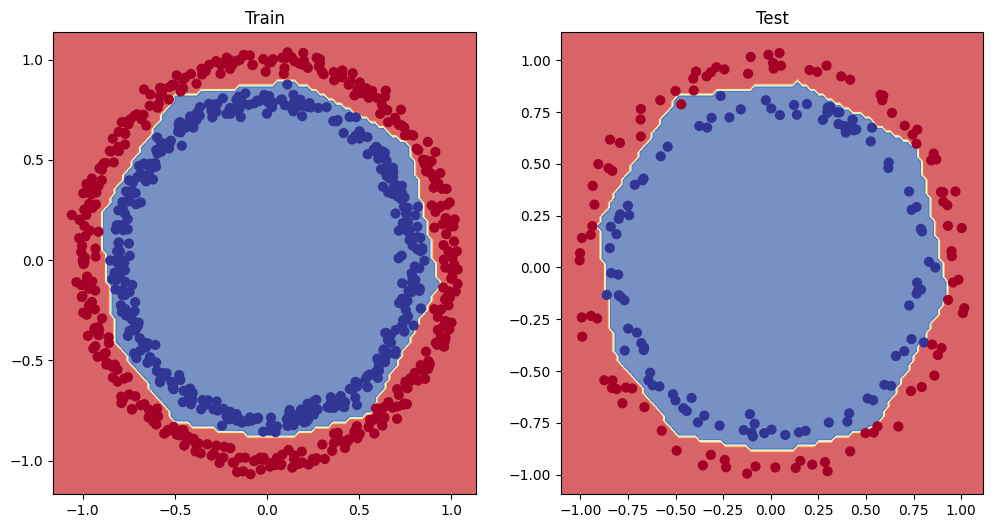

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_non_linear,X_train,y_train)
plt.title("Train")
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_non_linear,X_test,y_test)

In [ ]:
### Replicating linear and non-Linear Activation functions.
Neural Networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure outt the patterns on its own.


And these tools are linear and non-linear activation functions.
